We start by importing Keras

In [ ]:

import numpy as np
import h5py as h5py
import PIL
import tensorflow as tf

# Others
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd


# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc


# Image and directories
import cv2
import os

#tensorflow and keras
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!wget "https://uwoca-my.sharepoint.com/:u:/g/personal/cbravoro_uwo_ca/Ea8hL1Qqz-1DqXPUkFg3_OkBkT_oOJ5EdvwX1YU_afWF1w?download=1"
!mv /content/Ea8hL1Qqz-1DqXPUkFg3_OkBkT_oOJ5EdvwX1YU_afWF1w?download=1 /content/drive/MyDrive/data.tar.gz
!tar xvzf /content/drive/MyDrive/data.tar.gz

Reading the Deprivation index file

In [ ]:
DeprInd = pd.read_csv('/content/EmbeddingData_C3_9528.csv')
DeprInd.describe()

,id,income,employment,education,health,crime,barriers,living_environment
count,36723.000000,36723.000000,36723.000000,36723.000000,36723.000000,36723.000000,36723.000000,36723.000000
mean,36922.291997,0.117011,0.077774,12.995546,-0.578348,0.211408,32.301551,25.645519
std,16424.963636,0.072170,0.043844,10.240666,0.718902,0.588681,10.587134,10.729679
min,2619.000000,0.006000,0.003000,0.013000,-3.215000,-2.354000,6.910000,5.450000
25%,24161.500000,0.057000,0.043000,4.481000,-1.089000,-0.199000,24.283000,17.527000
50%,37072.000000,0.103000,0.067000,10.925000,-0.563000,0.221000,31.270000,24.350000
75%,50001.500000,0.163000,0.102000,19.086000,-0.039000,0.627000,39.506000,31.997000
max,74739.000000,0.437000,0.317000,58.976000,1.570000,2.377000,70.456000,91.602000


In [ ]:
DeprInd.head()

,id,LSOA11CD,LSOA11NM,SOAC11CD,SOAC11NM,MSOA11CD,MSOA11NM,LAD17CD,LAD17NM,LACCD,LACNM,income,employment,education,health,crime,barriers,living_environment
0,48552,E01000759,Bromley 034A,8a,Affluent communities,E02000160,Bromley 034,E09000006,Bromley,1a1r,Rural-Urban Fringe,0.025,0.042,7.632,-1.345,-0.139,30.886,13.902
1,46571,E01000759,Bromley 034A,8a,Affluent communities,E02000160,Bromley 034,E09000006,Bromley,1a1r,Rural-Urban Fringe,0.025,0.042,7.632,-1.345,-0.139,30.886,13.902
2,21161,E01000487,Brent 006E,7b,Young ethnic communities,E02000098,Brent 006,E09000005,Brent,4a1r,Ethnically Diverse Metropolitan Living,0.123,0.068,7.192,-0.782,0.109,40.432,21.233
3,26188,E01004572,Wandsworth 016A,6a,Inner city cosmopolitan,E02000938,Wandsworth 016,E09000032,Wandsworth,5a1r,London Cosmopolitan,0.142,0.090,8.750,-0.328,1.062,35.035,21.583
4,46276,E01033320,Lewisham 017E,6a,Inner city cosmopolitan,E02000669,Lewisham 017,E09000023,Lewisham,4a1r,Ethnically Diverse Metropolitan Living,0.125,0.105,7.185,-0.143,0.133,32.410,38.222


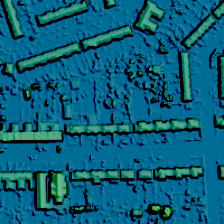

In [ ]:
from IPython.display import Image
#Image(filename='/content/LIDAR/LIDAR_0.png')
Image(filename='/content/LIDAR/LIDAR_46276.png')



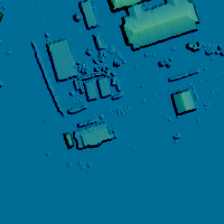

In [ ]:
Image(filename='/content/LIDAR/LIDAR_10010.png')

In [ ]:
# # Image Parameters
# ImageSize = (224,224)
# BatchSize = 128

Flow from dataframe- combine LIDAR images with the deprivation index dataset

In [ ]:
ImagePath = '/content/LIDAR/'
DeprInd['path'] = [os.path.join(ImagePath + 'LIDAR_'+ str(i) + '.png') for i in DeprInd.id]
DeprInd.head()

,id,LSOA11CD,LSOA11NM,SOAC11CD,SOAC11NM,MSOA11CD,MSOA11NM,LAD17CD,LAD17NM,LACCD,LACNM,income,employment,education,health,crime,barriers,living_environment,path
0,48552,E01000759,Bromley 034A,8a,Affluent communities,E02000160,Bromley 034,E09000006,Bromley,1a1r,Rural-Urban Fringe,0.025,0.042,7.632,-1.345,-0.139,30.886,13.902,/content/LIDAR/LIDAR_48552.png
1,46571,E01000759,Bromley 034A,8a,Affluent communities,E02000160,Bromley 034,E09000006,Bromley,1a1r,Rural-Urban Fringe,0.025,0.042,7.632,-1.345,-0.139,30.886,13.902,/content/LIDAR/LIDAR_46571.png
2,21161,E01000487,Brent 006E,7b,Young ethnic communities,E02000098,Brent 006,E09000005,Brent,4a1r,Ethnically Diverse Metropolitan Living,0.123,0.068,7.192,-0.782,0.109,40.432,21.233,/content/LIDAR/LIDAR_21161.png
3,26188,E01004572,Wandsworth 016A,6a,Inner city cosmopolitan,E02000938,Wandsworth 016,E09000032,Wandsworth,5a1r,London Cosmopolitan,0.142,0.090,8.750,-0.328,1.062,35.035,21.583,/content/LIDAR/LIDAR_26188.png
4,46276,E01033320,Lewisham 017E,6a,Inner city cosmopolitan,E02000669,Lewisham 017,E09000023,Lewisham,4a1r,Ethnically Diverse Metropolitan Living,0.125,0.105,7.185,-0.143,0.133,32.410,38.222,/content/LIDAR/LIDAR_46276.png


In [ ]:
DeprInd.shape

(36723, 19)

In [ ]:
DeprInd.to_csv("finalfile.csv",index=False)

#Train test split

In [ ]:
# Create a train / test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(DeprInd, 
                               test_size = 0.3,
                               random_state = 251253766) # add student id as random state

In [ ]:
print(train.shape)
print(test.shape)

(25706, 19)
(11017, 19)


#Create base VGG16 model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(weights = 'imagenet',      # The weights from the ImageNet competition
              include_top = False,       # Do not include the top layer, which classifies.
              input_shape= (224, 224, 3) # Input shape. Three channels, and BGR
             )

58900480/58889256 [==============================] - 0s 0us/step


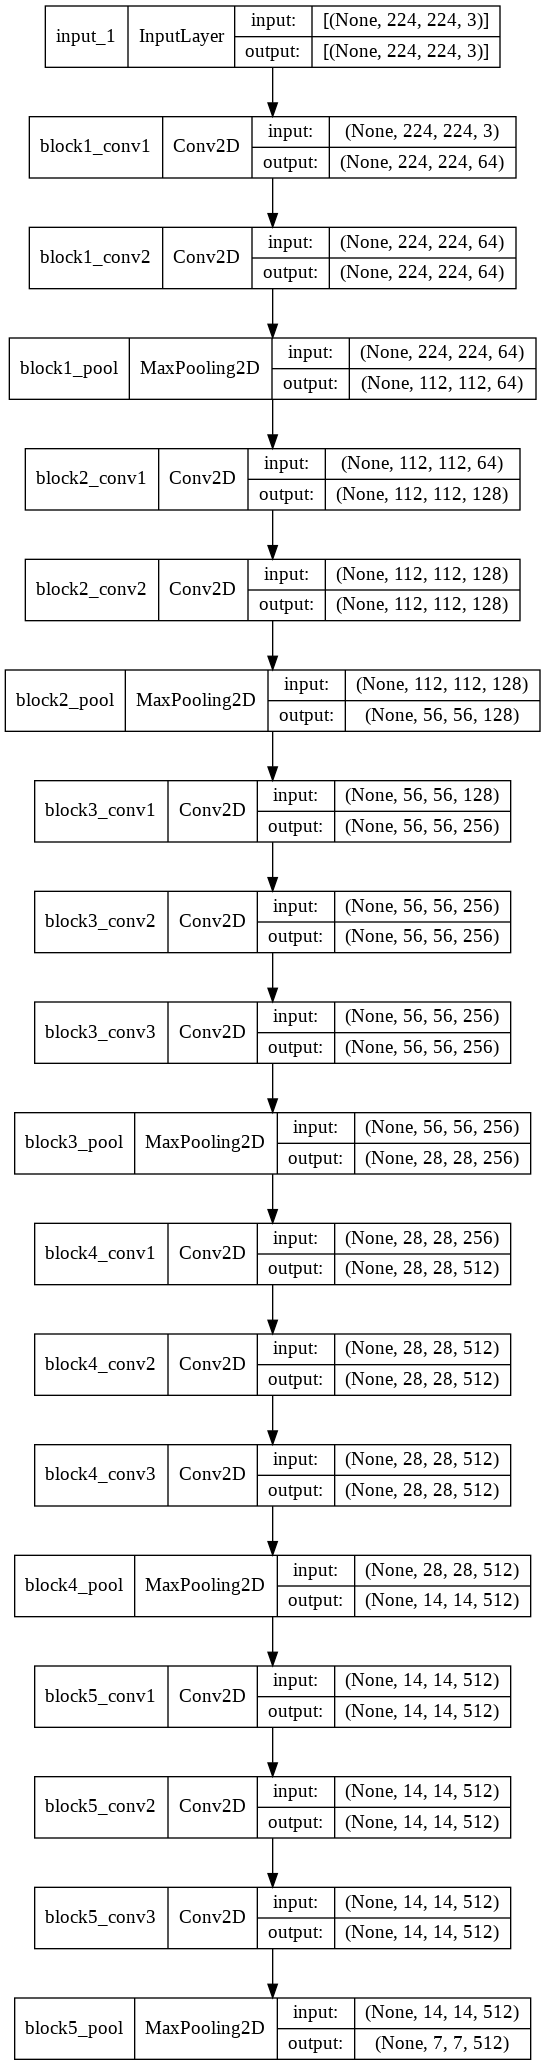

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

Creating model with untrinable layers and new dense layers

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [ ]:
# Create new model
CBModel = Sequential()

# Copy the layers to our new model. This needs to be done as there is a bug in Keras.
for layer in model.layers:
    CBModel.add(layer)

# Set the layers as untrainable
for layer in CBModel.layers:
    layer.trainable = False

In [ ]:
# Set layer as trainable.
CBModel.layers[15].trainable = True
CBModel.layers[16].trainable = True

In [ ]:
# We now add the new layers for prediction.
CBModel.add(Flatten(input_shape=model.output_shape[1:]))
CBModel.add(Dense(64, activation = 'relu'))
CBModel.add(Dropout(0.5))
CBModel.add(Dense(64, activation = 'relu'))
CBModel.add(Dropout(0.5))
CBModel.add(Dense(1, activation = 'relu')) # output is a linear function to predict living environment

In [ ]:
# What does the model look like?
CBModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

#Compiling the model


In [ ]:
# Compiling the model!
#import tensorflow.keras as keras

opt = optimizers.Adam(learning_rate=1e-5,            # Learning rate needs to be tweaked for convergence and be small!
                      decay=1e-3 / 200    # Decay of the LR 10^-3 / 1 / 50 / 100 / 200
                      )
CBModel.compile(loss=keras.losses.MeanSquaredError(), # Regression Loss
                optimizer=opt, 
              )

Image data generation- VGG16

In [ ]:
# prepare data augmentation configuration. One for train, one for test.
target_size = (224, 224)
batch_size = 256
DataDir = '/content/LIDAR/'


# Define generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                  rescale=1./255,                         # Inputs are scaled in the preprocessing function
                                  shear_range=0,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=1./255,                        # Inputs are scaled in the preprocessing function
                                  shear_range=0,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  )

# Point to the data and **give the targets**. Note the "raw" class_mode
train_generator = train_datagen.flow_from_dataframe(train,
                                                    directory='.',  # Look from root directory
                                                    x_col='path',   # Path to images
                                                    y_col='living_environment',  # Target
                                                    target_size=target_size, # Same as last lab
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='training',
                                                    interpolation="bilinear"
                                                   )

validation_generator = train_datagen.flow_from_dataframe(train,
                                                    directory='.',
                                                    x_col='path',
                                                    y_col='living_environment',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    interpolation="bilinear"
                                                   )

test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='.',
                                                  x_col='path',
                                                  y_col='living_environment',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='raw',
                                                  interpolation="bilinear"
                                                  )



Found 20565 validated image filenames.
Found 5141 validated image filenames.
Found 11017 validated image filenames.


In [ ]:
train_generator.samples//train_generator.batch_size
validation_generator.samples//validation_generator.batch_size
# np.amax([validation_generator.samples // validation_generator.batch_size, 1])

20

Loading the data file and splitting into train and test

#Training


Priming the model with 2 epochs.

In [ ]:
# Number of epochs
epochs = 10

# Train!
CBModel.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            steps_per_epoch = train_generator.samples//train_generator.batch_size, # Usually cases / batch_size = 160. 
            validation_steps = validation_generator.samples//validation_generator.batch_size # Number of validation steps. Again cases / batch_size = 20.
          )

Epoch 1/10
80/80 [==============================] - 316s 4s/step - loss: 198.5642 - val_loss: 79.1979
Epoch 2/10
80/80 [==============================] - 305s 4s/step - loss: 193.5176 - val_loss: 77.7606
Epoch 3/10
80/80 [==============================] - 304s 4s/step - loss: 191.0668 - val_loss: 84.4767
Epoch 4/10
80/80 [==============================] - 303s 4s/step - loss: 185.1550 - val_loss: 80.1827
Epoch 5/10
80/80 [==============================] - 304s 4s/step - loss: 186.3592 - val_loss: 81.4977
Epoch 6/10
80/80 [==============================] - 304s 4s/step - loss: 186.7633 - val_loss: 88.9467
Epoch 7/10
80/80 [==============================] - 303s 4s/step - loss: 179.1846 - val_loss: 81.6659
Epoch 8/10
80/80 [==============================] - 304s 4s/step - loss: 176.4626 - val_loss: 81.1754
Epoch 9/10
80/80 [==============================] - 304s 4s/step - loss: 177.0326 - val_loss: 82.2359
Epoch 10/10
80/80 [==============================] - 313s 4s/step - loss: 174.4736

Checking the convergence plot before actual training

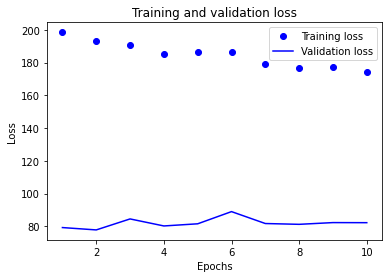

In [ ]:
loss = CBModel.history.history['loss']
val_loss = CBModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

To train the non dense layers

Saving model

In [ ]:
# Activating Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Saving the model
CBModel.save('/content/drive/MyDrive/VGG16_FM9528A_V1.h5')



In [ ]:
#Loading
CBModel = keras.models.load_model('/content/drive/MyDrive/VGG16_FM9528A_V1.h5')

Restoring the best model

In [ ]:
# Applying to the test set with a generator.
test_generator.reset()

# Get predictions
output_vgg = CBModel.predict(test_generator)

In [ ]:
output_vgg

array([[21.389135],
       [42.07809 ],
       [20.046844],
       ...,
       [19.769209],
       [20.185917],
       [28.400835]], dtype=float32)

In [ ]:
test_generator.labels

array([11.187, 48.228, 11.657, ..., 15.814, 11.387, 22.131])

Root Mean Squared Error

In [ ]:
# Root Mean Squared Error
def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))


In [ ]:
def mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

In [ ]:
rmse_vgg = root_mean_squared_error(test_generator.labels, output_vgg)
print('The root mean squared error over the test for VGG model is %.2f' % rmse_vgg)
mse_vgg = mean_squared_error(test_generator.labels, output_vgg)
print('The mean squared error over the test for VGG model is %.2f' % mse_vgg)

The root mean squared error over the test for VGG model is 12.88
The mean squared error over the test for VGG model is 165.84


#Resnet

In [ ]:
# Import base model. Using ResNet50v2.
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [ ]:


# Import model with input layer
base_model = ResNet50V2(weights = 'imagenet',     # The weights from the ImageNet competition
                      include_top = False,       # Do not include the top layer, which classifies.
                      input_shape= (224, 224, 3) # Input shape. Three channels.
                      )

94683136/94668760 [==============================] - 2s 0us/step


In [ ]:
# Parameters
ImageSize = (224,224)
BatchSize = 128

In [ ]:
# Set the base model to untrainable.
base_model.trainable = False

In [ ]:
# Create the full model using the Model API

# Input layer
inputs = keras.Input(shape=ImageSize + (3,),
                        name = 'image_only_input')

# Add the ResNet model, setting it to be untrainable. 
# First we store it on a temporary variable.
x = base_model(inputs, training=False)

# Flatten to make it the same size as the original model
x = Flatten()(x)

# Now we actually add it to a layer. Note the way of writing it.
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Add final output layer.
outputs = Dense(1, activation='relu')(x)

# Create the complete model object
ImageOnlyModel = keras.Model(inputs, outputs)

In [ ]:
# This is what the model looks like now.
ImageOnlyModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_only_input (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                             

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
# Compiling the model! Note the learning rate.
opt = optimizers.Adam(learning_rate=1e-6,            # Learning rate needs to be tweaked for convergence and be small!
                      decay=1e-3 / 200    # Decay of the LR 10^-3 / 1 / 50 / 100 / 200
                      ) 
ImageOnlyModel.compile(loss=keras.losses.MeanSquaredError(), # This is NOT a classification problem!
                      optimizer=opt
                       )

Data generation for Resnet

In [ ]:
# Define parameters

target_size = (224, 224)
batch_size = 128
DataDir = '/content/LIDAR/'

# Define generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                  rescale=None,                         # Inputs are scaled in the preprocessing function
                                  shear_range=0,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                     # Flip horizontally?
                                  vertical_flip=False,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # ResNet expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=None,                        # Inputs are scaled in the preprocessing function
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                     # Flip horizontally?
                                  vertical_flip=False,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  )

# Point to the data and **give the targets**. Note the "raw" class_mode
train_generator = train_datagen.flow_from_dataframe(train,
                                                    directory='.',  # Look from root directory
                                                    x_col='path',   # Path to images
                                                    y_col='living_environment',  # Target
                                                    target_size=target_size, # Same as last lab
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='training',
                                                    interpolation="bilinear"
                                                   )

validation_generator = train_datagen.flow_from_dataframe(train,
                                                    directory='.',
                                                    x_col='path',
                                                    y_col='living_environment',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    interpolation="bilinear"
                                                   )

test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='.',
                                                  x_col='path',
                                                  y_col='living_environment',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='raw',
                                                  interpolation="bilinear"
                                                  )

Found 20565 validated image filenames.
Found 5141 validated image filenames.
Found 11017 validated image filenames.


Warm start and priming of model

In [ ]:
# Number of epochs
epochs = 2

# Train!
ImageOnlyModel.fit(
                  train_generator,
                  epochs=epochs,
                  validation_data=validation_generator,
                  steps_per_epoch = 3, # Usually cases / batch_size = 3.
                  validation_steps = 1 # Number of validation steps. Again cases / batch_size = 1.
                  )

Epoch 1/2
3/3 [==============================] - 52s 24s/step - loss: 752.8106 - val_loss: 811.0211
Epoch 2/2
3/3 [==============================] - 8s 3s/step - loss: 733.7498 - val_loss: 770.1473


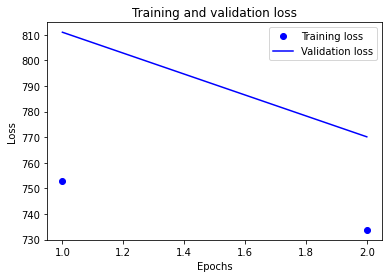

In [ ]:
# Plotting training history.
loss = ImageOnlyModel.history.history['loss']
val_loss = ImageOnlyModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We will now train non dense layers

In [ ]:
base_model.trainable = True

# Recompile as we changed things.
ImageOnlyModel.compile(loss=keras.losses.MeanSquaredError(), # This is NOT a classification problem!
                      optimizer=opt
                       )

ImageOnlyModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_only_input (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                             

Call backs and model training

In [ ]:
# Define callbacks
#checkpoint_path='/checkpoints/ImageOnlyModel.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint_path='/content/drive/MyDrive/checkpoints/ImageOnlyModel.{epoch:02d}-{val_loss:.2f}.h5'

checkpoint_dir=os.path.dirname(checkpoint_path)
checkpoint_dir

'/content/drive/MyDrive/checkpoints'

In [ ]:
# Define callbacks
#checkpoint_path='checkpoints/ImageOnlyModel.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint_path='/content/drive/MyDrive/checkpoints/ImageOnlyModel.{epoch:02d}-{val_loss:.2f}.h5'

checkpoint_dir=os.path.dirname(checkpoint_path)

my_callbacks = [
    # Stop training if validation error stays within 0.00001 for three rounds.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=0.00001,
                                     patience=3),
    # Save the weights of the best performing model to the checkpoint folder.
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       save_weights_only=True),
]

# Number of epochs
epochs = 20

# Train!
ImageOnlyModel.fit(
                  train_generator, # Pass the train generator
                  epochs=epochs, # Pass the epochs
                  validation_data=validation_generator, # Pass the validation generator
                  steps_per_epoch = train_generator.samples//train_generator.batch_size,  # Usually cases / batch_size 
                  validation_steps = validation_generator.samples//validation_generator.batch_size,  # Number of validation steps. Again cases / batch_size 
                  callbacks=my_callbacks # Add the callbacks
                  )

Epoch 1/20
160/160 [==============================] - 331s 2s/step - loss: 469.0233 - val_loss: 145.3185
Epoch 2/20
160/160 [==============================] - 325s 2s/step - loss: 245.2115 - val_loss: 118.0729
Epoch 3/20
160/160 [==============================] - 323s 2s/step - loss: 229.7025 - val_loss: 111.7264
Epoch 4/20
160/160 [==============================] - 323s 2s/step - loss: 224.7601 - val_loss: 105.3560
Epoch 5/20
160/160 [==============================] - 322s 2s/step - loss: 218.5129 - val_loss: 97.4457
Epoch 6/20
160/160 [==============================] - 323s 2s/step - loss: 211.7424 - val_loss: 95.6826
Epoch 7/20
160/160 [==============================] - 324s 2s/step - loss: 212.7580 - val_loss: 95.5370
Epoch 8/20
160/160 [==============================] - 326s 2s/step - loss: 207.9579 - val_loss: 90.4813
Epoch 9/20
160/160 [==============================] - 324s 2s/step - loss: 206.1017 - val_loss: 89.9827
Epoch 10/20
160/160 [==============================] - 325s 

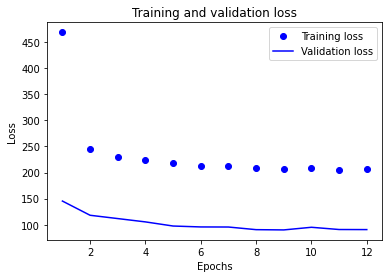

In [ ]:
# Plotting training history.
loss = ImageOnlyModel.history.history['loss']
val_loss = ImageOnlyModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Restoring best model

In [ ]:
# Load the weights. THIS REQUIRES FIRST CREATING THE LOGIC.
ImageOnlyModel.load_weights('/content/drive/MyDrive/checkpoints/ImageOnlyModel.09-89.98.h5') # replace this name with the best performing model


Test prediction

In [ ]:
# Applying to the test set with a generator.
test_generator.reset()

# Get probabilities
output = ImageOnlyModel.predict(test_generator)

In [ ]:
test_generator

In [ ]:
import sys
#import numpy
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
display(output)

In [ ]:
test_generator.labels

array([11.187, 48.228, 11.657, ..., 15.814, 11.387, 22.131])

In [ ]:
rmse_resnet = root_mean_squared_error(test_generator.labels, output)
print('The root mean square error over the test for Resnetmodel is %.2f' % rmse_resnet)
mse_resnet = mean_squared_error(test_generator.labels, output)
print('The mean squared error over the test for VGG model is %.2f' % mse_resnet)

The root mean square error over the test for Resnetmodel is 12.46
The mean squared error over the test for VGG model is 155.33


In [ ]:
max_test = np.max(test_generator.labels)
min_test = np.min(test_generator.labels)
#norm_rmse_vgg = rmse_vgg/(max_test-min_test)
norm_rmse_resnet = rmse_resnet/(max_test-min_test)
#print("normalised rmse for vgg over test is %.3f" % norm_rmse_vgg)
print("normalised rmse for resnet over test is %.3f" % norm_rmse_resnet)

normalised rmse for resnet over test is 0.145


In [ ]:

base_model.summary()

In [ ]:
ImageOnlyModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_only_input (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                             

#GradCam

In [ ]:
ImageOnlyModel.layers[1].get_layer(last_conv_layer_name)

In [ ]:
# The explainer. Gotten from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    from tensorflow import keras
    import tensorflow as tf
    # First, we create a model that maps the input image to the activations
    # of the last conv layer. This layer is located at model.layers[1] as the
    # ResNet model is the first "layer" of the ImageOnlyModel. Modify as needed.
    
    last_conv_layer = model.layers[1].get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.layers[1].inputs, last_conv_layer.output)

    # last_conv_layer = base_model.get_layer(last_conv_layer_name)
    # last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    regression_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = regression_input
    for layer_name in classifier_layer_names:
        try:
            x = model.get_layer(layer_name)(x)
        except:
            x = model.layers[1].get_layer(layer_name)(x)
    regression_model = keras.Model(regression_input, x)

 
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer

    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute predictions
        top_class_channel = regression_model(last_conv_layer_output)
       


    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the regression
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    # print(last_conv_layer_output)
    # print(heatmap)
    # print(np.max(heatmap))
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

In [ ]:
# # Set the layers. # trying with vgg
# last_conv_layer_name = "block5_conv3"
# classifier_layer_names =  ["block5_pool",
#                            "dense",                           
#                            "dense_1",
#                            "dense_2",]

In [ ]:
last_conv_layer_name = "post_relu"
#last_conv_layer_name = "conv5_block3_out"
 
classifier_layer_names =  ["flatten",
                           "dense",
                           "dropout",
                           "dense_1",
                           "dropout_1",
                           "dense_2",]

Loading random images and plotting heatmaps

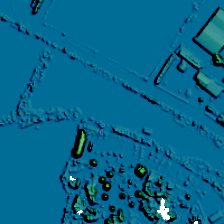

In [ ]:
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Get the image in the right size
def get_img_array(img_path, size = (224, 224)):
    import tensorflow as tf
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array

# Get an image
img_path = '/content/LIDAR/LIDAR_64774.png' # pick an image
data = get_img_array(img_path)

# Plot it
display(Image(img_path))

GradRam estimate

[[0.09705488 0.188017   0.2843762  0.14159058 0.15692163 0.34596252
  0.25399876]
 [0.14867824 0.3525952  0.44636166 0.10878056 0.18164127 0.49411422
  0.36233315]
 [0.17501602 0.58807176 0.8452461  0.2849584  0.54350185 0.7443358
  0.5656265 ]
 [0.06603655 0.2550343  0.71168214 0.29863393 0.47405562 0.6005398
  0.40790316]
 [0.03181586 0.18213327 0.616528   0.33383268 0.3792645  0.62592554
  0.40378892]
 [0.14077865 0.44248793 0.8551589  0.4104448  0.59493035 1.
  0.579672  ]
 [0.12425995 0.4670375  0.6403909  0.45414543 0.54945207 0.82881
  0.39616168]]


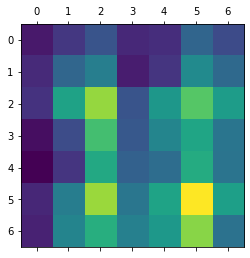

In [ ]:
#Plot the heatmap! trying with vgg
heatmap = make_gradcam_heatmap(
    preprocess_input(data), ImageOnlyModel, last_conv_layer_name, classifier_layer_names
)
# heatmap = make_gradcam_heatmap(
#     preprocess_input(data), ImageOnlyModel, last_conv_layer_name, classifier_layer_names
# )

#Display heatmap

print(heatmap)

plt.matshow(heatmap)
plt.show()

Superimposing heatmap on image

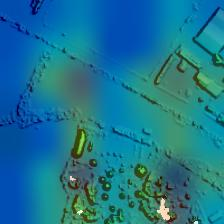

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "Lidar49078.jpg"
superimposed_img.save(save_path)

# Display Grad RAM
display(Image(save_path))
